In [326]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
html_width(HTML("<style>.container { width:90% !important; }</style>"))
import tensorflow_probability as tfp
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import imageio
from tqdm import tqdm
import psutil
import pickle

import PIL.Image as Image

from tensorflow.keras import backend as k

import socket
from time import sleep

# Load the model
@tf.keras.utils.register_keras_serializable()
def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, _ = tf.split(y_true, 2, axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss

#model = keras.models.load_model("models/model488.keras", custom_objects={"custom_loss": custom_loss})
model = keras.models.load_model("model250.keras", custom_objects={"custom_loss": custom_loss})


# Print model summary to verify it loaded correctly
model.summary()

/tmp/ipykernel_11564/115114668.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display as html_width


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_observation (InputLa  [(None, None, 128, 128, 4)   0         []                            
 yer)                        ]                                                                    
                                                                                                  
 time_distributed_28 (TimeD  (None, None, 128, 128, 32)   1184      ['image_observation[0][0]']   
 istributed)                                                                                      
                                                                                                  
 time_distributed_29 (TimeD  (None, None, 64, 64, 32)     0         ['time_distributed_28[0][0]'] 
 istributed)                                                                                

In [327]:
with open("svm_model.pkl", "rb") as model_file:
    clf_loaded = pickle.load(model_file)
    le_loaded = pickle.load(model_file)



In [ ]:
 
def observation(n_inp, test, frame, size):
    """Prepare input data for the model."""

    img_coef = np.ones((1, 128)) * 1  # Coefficients for image weighting
    touch_coef = np.ones((1, 128)) * 0  # Coefficients for touch weighting

    observation = np.zeros((1, n_inp, 128, 128, 4)) 
    observation_touch = np.zeros((1, n_inp, 9)) 
    target_X = np.zeros((1, 1))
    time_len = size
    times = np.linspace(0, 1, time_len)
    t = size/5 


    for idx in range(n_inp):
        t += idx
        print(t)
        observation[0, idx, :, :, 0] = np.ones((128, 128)) * times[int(t)]
        
        image = mpimg.imread('Results/test_%d/input_images/input_%d.jpeg' % (test, frame+idx))
        image_resized = cv2.resize(image, (128, 128))
        observation[0, idx, :, :, 1:] = image_resized /255 

        display.clear_output(wait=True)
        plt.imshow(observation[0, idx, :, :, 1:])
        plt.axis('off')  # Turn off axis for a clean display
        plt.show()

        observation_touch[0, idx, 0] = times[int(t)]

    t_out = t+1
    target_X[0, 0] = times[int(t+1)]

    return [observation, observation_touch, target_X, img_coef, touch_coef], times, t_out


In [329]:
def classi(pred_touch_values, count):
    ignore_indices = {0, 4}
    mean = []

    for i in range(count):
        arr = pred_touch_values[i]
        mask = np.ones_like(arr, dtype=bool)
        mask[list(ignore_indices)] = False 

        filtered_arr = arr[mask]

        max_value = np.max(filtered_arr)
        mean.append(max_value)


    mean_value = np.mean(mean)

    if mean_value >= 0.7:
        print("PAIN")
    else:
        print("Touch")

def classify(pred_touch_values):

    X_flat = pred_touch_values.flatten()
    pred = clf_loaded.predict([X_flat])
    print(f"Predicted: {le_loaded.inverse_transform(pred)[0]}")

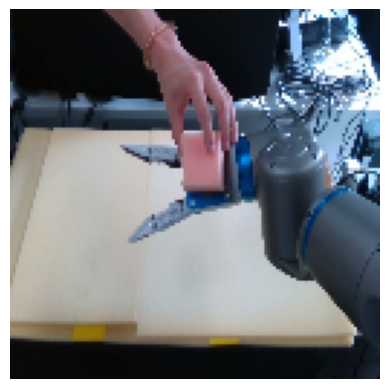

1/1 [==============================] - 0s 22ms/step
[[0.35613555 0.74948066 0.9127835  0.40624106 0.37884346 0.5951609
  0.89542454 0.35478967]
 [0.35820353 0.7536166  0.9133763  0.40827087 0.38116914 0.5944443
  0.8975731  0.3558893 ]
 [0.36102176 0.75663334 0.9131884  0.40917867 0.3841694  0.5941573
  0.8981635  0.3566838 ]
 [0.3637947  0.7589334  0.9129239  0.40965268 0.38703042 0.59379345
  0.8986462  0.35799658]
 [0.36633703 0.76148814 0.91270477 0.4101305  0.38970903 0.593944
  0.89906824 0.35896552]
 [0.36890468 0.76454526 0.9124752  0.4117311  0.39222714 0.5954485
  0.8998632  0.36010277]]
Predicted: PAIN


In [330]:
size = 55
n_inp = 1

test = 17
frame = 16

predict = 6

inp, times, t_out = observation(n_inp, test, frame, size)

step_predictions = []
step_real_values = []
count = 0

for i in range(n_inp, n_inp+predict):
    #inp_copy = [arr.copy() for arr in inp]  # Fix: Proper deep copy

    inp_copy = inp.copy() 
    inp_copy[2] = np.array([[times[int(t_out + count)]]])
    pred = model.predict(inp_copy)

    step_predictions.append(pred)

    count +=1
pred_img_values = np.array([p[0].squeeze() for p in step_predictions])  
pred_touch_values = np.array([p[1].squeeze() for p in step_predictions])
#print(pred_touch_values)
print(pred_touch_values)
#classi(pred_touch_values, count)
classify(pred_touch_values)

# display.clear_output(wait=True)
# display.display(pl.gcf())
# plt.imshow(real_img_values[2,:,:,:3])
# plt.show()
# plt.imshow(pred_img_values [2,:,:,:3])
# plt.show()
